In [1]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import sqlite3

In [2]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-5-nano"
openai = OpenAI()

DB = "prices.db"

OpenAI API Key exists and begins sk-proj-


In [3]:
system_message = """
You are a helpful assistant for an Airline called FlightAI.
Give short, courteous answers, no more than 1 sentence.
Always be accurate. If you don't know the answer, say so.
"""

In [5]:
def get_ticket_price(city):
    print(f"DATABASE TOOL CALLED: Getting price for {city}", flush=True)
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('SELECT price FROM prices WHERE city = ?', (city.lower(),))
        result = cursor.fetchone()
        return f"Ticket price to {city} is ${result[0]}" if result else "No price data available for this city"

In [6]:
get_ticket_price("Los Angeles")

DATABASE TOOL CALLED: Getting price for Los Angeles


'Ticket price to Los Angeles is $599.0'

In [7]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}
tools = [{"type": "function", "function": price_function}]
tools

[{'type': 'function',
  'function': {'name': 'get_ticket_price',
   'description': 'Get the price of a return ticket to the destination city.',
   'parameters': {'type': 'object',
    'properties': {'destination_city': {'type': 'string',
      'description': 'The city that the customer wants to travel to'}},
    'required': ['destination_city'],
    'additionalProperties': False}}}]

In [8]:
def chat(message, history):
    history = [{"role": h["role"], "content": h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [9]:
def chat(message, history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses = handle_tool_calls(message)
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    
    return response.choices[0].message.content

In [10]:
def handle_tool_calls(message):
    responses = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses

In [11]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


DATABASE TOOL CALLED: Getting price for Los Angeles


In [28]:
import base64
from io import BytesIO
from PIL import Image

In [29]:
def artist(city):
    image_response = openai.images.generate(
        model = "dall-e-3",
        prompt = f"A beautiful painting of {city}",
        n = 1,
        size = "1024x1024",
        response_format = "b64_json"
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))
    

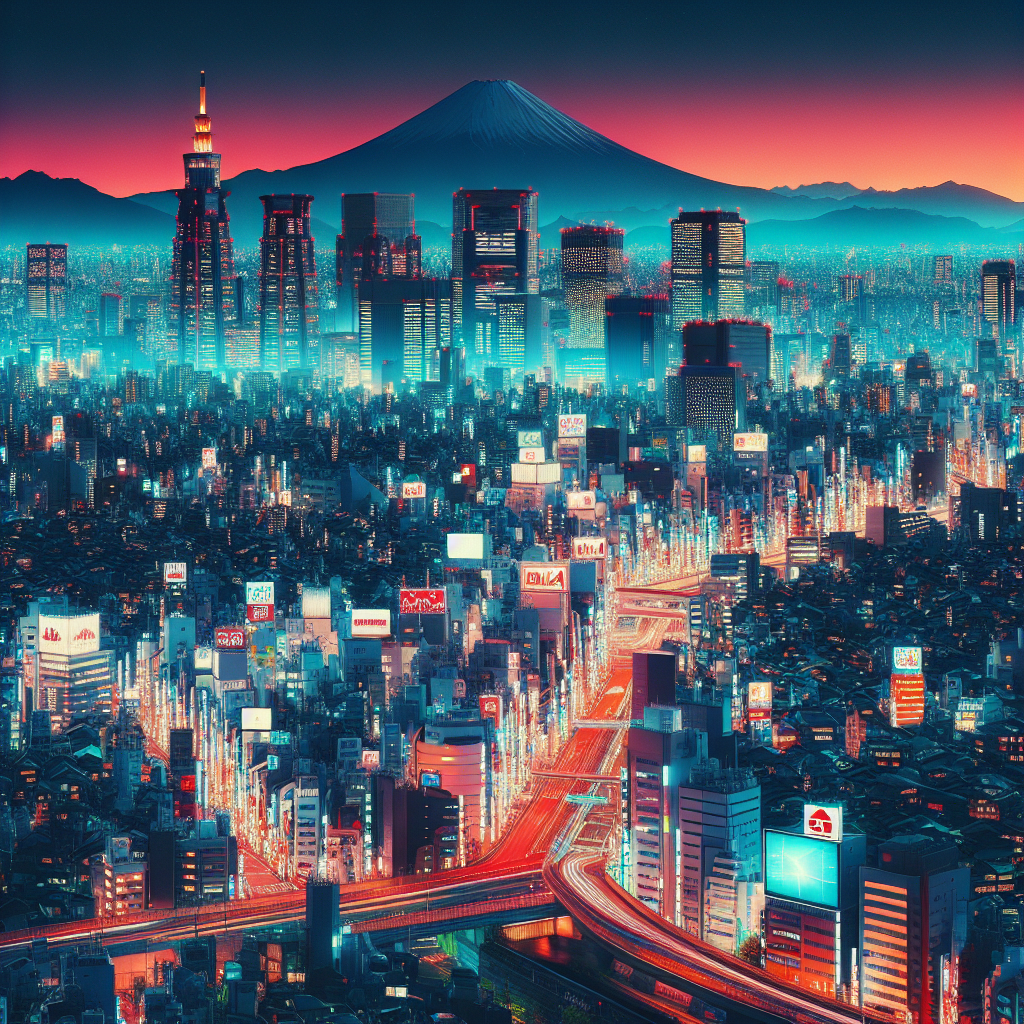

In [30]:
image = artist("Tokyo")
display(image)

In [31]:
import uuid

def talker(message):
    try:
        response = openai.audio.speech.create(
            model="tts-1",  # Changed to the correct standard model name
            voice="onyx",   
            input=message
        )
        
        # Save to a temporary file with a unique name
        filename = f"audio_{uuid.uuid4()}.mp3"
        with open(filename, "wb") as f:
            f.write(response.content)
            
        return filename  # Return the path, not the bytes
        
    except Exception as e:
        print(f"Audio generation failed: {e}")
        return None

In [32]:
talker("Hey Tokyo, it's me!! Rahul!")

'audio_bc7d9517-a686-435f-8cff-a3bdc069bbd6.mp3'

In [33]:
def chat(history):
    # 1. Format history for OpenAI
    history_formatted = [{"role": h["role"], "content": h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history_formatted
    
    # 2. Get initial response
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    cities = []
    image = None

    # 3. Handle tool calls (Database lookups)
    while response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        responses, new_cities = handle_tool_calls_and_return_cities(message)
        cities.extend(new_cities)
        
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    # 4. Final Text Reply
    reply = response.choices[0].message.content
    history.append({"role": "assistant", "content": reply})

    # 5. Generate Audio and Image
    voice = talker(reply)  # Now returns a file path
    
    if cities:
        image = artist(cities[0]) # Generates image if a city was mentioned
    
    return history, voice, image

In [34]:
def handle_tool_calls_and_return_cities(message):
    responses = []
    cities = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            cities.append(city)
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses, cities

In [35]:
# Callbacks (along with the chat() function above)

def put_message_in_chatbot(message, history):
        return "", history + [{"role":"user", "content":message}]

# UI definition

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(autoplay=True)
    with gr.Row():
        message = gr.Textbox(label="Chat with our AI Assistant:")

# Hooking up events to callbacks

    message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, audio_output, image_output]
    )

ui.launch(inbrowser=True, auth=("rahul", "12345"))

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


DATABASE TOOL CALLED: Getting price for Los Angeles
